# ctf-UCBVI on CartPole with Wind PCH

This notebook demonstrates the training and visualization of Upper Confidence Bound Value Iteration (UCBVI) and Upper Confidence Bound Q-Learning (UCBQ) algorithms on the CartPole with Wind environment using Potential Causal History (PCH).

The environment is a modified version of the classic CartPole problem where wind effects can alter the intended actions.

In [1]:
import os
import sys
import time
from typing import List, Tuple, Any

import gymnasium as gym
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from IPython.display import HTML, display

from causal_gym.envs.cartpole_wind import CartPoleWindPCH
from causal_rl.algo.ctf_do.ucbvi import UCBVI
from causal_rl.algo.ctf_do.ucbq import UCBQ

In [2]:
class Discretiser:
    """
    Discretises continuous observation space for CartPoleWindPCH into integer states.
    Uses symmetric ranges:
      position ∈ [-2.4, 2.4], velocity ∈ [-3.0, 3.0],
      angle ∈ [-0.20, 0.20], angular-vel ∈ [-3.5, 3.5].
    """
    def __init__(self, bins_per_dim: int):
        if not isinstance(bins_per_dim, int) or bins_per_dim <= 0:
            raise ValueError("bins_per_dim must be a positive integer.")
        self.bins_per_dim_each = np.array([bins_per_dim] * 4, dtype=np.int_)

        self.obs_low = np.array([-2.4, -3.0, -0.20, -3.5], dtype=np.float32)
        self.obs_high = np.array([2.4, 3.0, 0.20, 3.5], dtype=np.float32)
        self.num_dims = 4

        self.bin_edges: List[np.ndarray] = []
        for i in range(self.num_dims):
            edges = np.linspace(self.obs_low[i], self.obs_high[i], self.bins_per_dim_each[i] + 1)
            self.bin_edges.append(edges)

        self._n_states = int(np.prod(self.bins_per_dim_each))
        if self._n_states <= 0:
            raise ValueError("Number of states must be positive.")

    def __call__(self, obs: np.ndarray) -> int:
        bin_indices = np.empty(self.num_dims, dtype=np.int_)
        for i in range(self.num_dims):
            clipped_obs_i = np.clip(obs[i], self.obs_low[i], self.obs_high[i])
            
            if self.bins_per_dim_each[i] == 1:
                bin_indices[i] = 0
            else:
                thresholds = self.bin_edges[i][1:-1] 
                bin_indices[i] = np.digitize(clipped_obs_i, thresholds)
        
        state_index = 0
        for i in range(self.num_dims):
            state_index = state_index * self.bins_per_dim_each[i] + bin_indices[i]
        return int(state_index)

    @property
    def n_states(self) -> int:
        return self._n_states

# Test the Discretiser
_test_bins = 8
_d_test = Discretiser(bins_per_dim=_test_bins)
assert _d_test.n_states == _test_bins**4, f"Test failed: n_states={_d_test.n_states}, expected={_test_bins**4}"
_test_obs = np.array([0.0, 0.0, 0.0, 0.0]) 
_test_idx = _d_test(_test_obs)
assert 0 <= _test_idx < _d_test.n_states, f"Test failed: idx={_test_idx} out of range for n_states={_d_test.n_states}"
print("Discretiser self-test passed.")

Discretiser self-test passed.


In [ ]:
# Training Configuration
CONFIG = {
    'episodes': 1000,
    'horizon': 200,
    'algo': 'ucbvi',  # or 'ucbq'
    'bins': 8,
    'delta': 0.1,
    'epsilon': 0.1,
    'seed': 0
}

ACTION_MAP = {0: "LEFT ", 1: "DOWN ", 2: "RIGHT", 3: "UP   "}

# Create output directory if needed
OUTPUT_DIR = "causal_rl/examples/outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [5]:
def train_agent(config):
    """Train the agent and return training history and the trained agent."""
    np.random.seed(config['seed'])
    env = CartPoleWindPCH()
    discretiser = Discretiser(bins_per_dim=config['bins'])
    
    print(f"Discretised states: {discretiser.n_states} (bins per dim: {config['bins']})")
    
    n_actions = env.action_space.n
    
    if config['algo'] == 'ucbvi':
        agent = UCBVI(
            num_states=discretiser.n_states,
            n_actions=n_actions,
            horizon=config['horizon'],
            delta=config['delta'],
            epsilon=config['epsilon'],
            seed=config['seed']
        )
    elif config['algo'] == 'ucbq':
        agent = UCBQ(
            n_states=discretiser.n_states,
            n_actions=n_actions,
            delta=config['delta']
        )
    else:
        raise ValueError(f"Unknown algorithm: {config['algo']}")
    
    episode_returns = []
    episode_regrets = []
    
    print(f"Starting training with {config['algo'].upper()} for {config['episodes']} episodes...")
    start_time = time.time()
    
    for ep in range(config['episodes']):
        obs_continuous, _ = env.reset(seed=config['seed'] + ep)
        s = discretiser(obs_continuous)
        ep_return = 0.0
        ep_regret_steps = 0.0
        
        if hasattr(agent, 'plan'):
            agent.plan()
            
        for t in range(config['horizon']):
            if config['algo'] == 'ucbvi':
                x_intended = np.argmax(agent.V[s, :])
                a_to_apply = agent.act(s, x_intended)
            else:
                a_to_apply = agent.act(s)
                
            obs2_continuous, r, terminated, truncated, info = env.do(a_to_apply)
            s2 = discretiser(obs2_continuous)
            done = terminated or truncated
            
            realised_action = info.get('realised_action', a_to_apply)
            
            if config['algo'] == 'ucbvi':
                agent.update(s, x_intended, realised_action, r, s2)
            else:
                agent.update(s, realised_action, r, s2)
                
            ep_return += r
            ep_regret_steps += (1.0 - r)
            s = s2
            
            if done:
                break
                
        episode_returns.append(ep_return)
        episode_regrets.append(ep_regret_steps)
        
        if (ep + 1) % max(1, config['episodes'] // 10) == 0 or ep == config['episodes'] - 1:
            print(f"Ep {ep+1:4d}/{config['episodes']} | Return: {ep_return:7.2f} | Steps: {t+1} | Regret this ep: {ep_regret_steps:.2f}")
            
    training_time = time.time() - start_time
    print(f"Training finished in {training_time:.2f} seconds.")
    
    return {
        'agent': agent,
        'discretiser': discretiser,
        'returns': episode_returns,
        'regrets': episode_regrets,
        'training_time': training_time
    }

## Visualization Functions

Below are functions for plotting training results and generating GIFs of the trained agent's performance.

In [6]:
def plot_training_results(history, config):
    """Plot training returns and cumulative regret."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot episode returns
    ax1.plot(history['returns'])
    if len(history['returns']) >= 50:
        moving_avg = np.convolve(history['returns'], np.ones(50)/50, mode='valid')
        ax1.plot(range(49, len(history['returns'])), moving_avg, 'r--', label='50-episode Moving Average')
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Episode Return')
    ax1.set_title(f'Episode Returns ({config["algo"].upper()})\nBins={config["bins"]}, H={config["horizon"]}')
    ax1.grid(True)
    ax1.legend()
    
    # Plot cumulative regret
    cumulative_regret = np.cumsum(history['regrets'])
    ax2.plot(cumulative_regret)
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Cumulative Regret')
    ax2.set_title(f'Cumulative Regret ({config["algo"].upper()})\nBins={config["bins"]}, H={config["horizon"]}')
    ax2.grid(True)
    
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, f'cartpole_training_{config["algo"]}.png'))
    plt.show()

In [7]:
def generate_gif(agent, discretiser, config):
    """Generate a GIF of the trained agent's performance."""
    gif_env = CartPoleWindPCH(render_mode="rgb_array")
    frames = []
    
    obs_cont, _ = gif_env.reset(seed=config['seed'] + config['episodes'] + 1)
    s = discretiser(obs_cont)
    ep_return = 0.0
    
    if hasattr(agent, 'plan'):
        agent.plan()
        
    for t in range(config['horizon']):
        frame = gif_env.render()
        if frame is not None:
            frames.append(frame)
            
        if config['algo'] == 'ucbvi':
            x_intended = np.argmax(agent.V[s, :])
            a = agent.act(s, x_intended)
        else:
            a = agent.act(s)
            
        obs2_cont, r, terminated, truncated, _ = gif_env.do(a)
        s = discretiser(obs2_cont)
        ep_return += r
        
        if terminated or truncated:
            break
            
    gif_env.close()
    print(f"GIF episode return: {ep_return:.2f}")
    
    if frames:
        fig = plt.figure()
        plt.axis('off')
        patch = plt.imshow(frames[0])
        
        def animate(i):
            patch.set_data(frames[i])
            return patch,
            
        anim = animation.FuncAnimation(fig, animate, frames=len(frames), interval=50, blit=True)
        plt.close()
        
        # Save GIF
        anim.save(os.path.join(OUTPUT_DIR, f'cartpole_{config["algo"]}.gif'), writer='pillow', fps=20)
        
        # Display in notebook
        return HTML(anim.to_jshtml())
    else:
        print("No frames collected for GIF.")
        return None

## Training and Visualization

Now let's train the agent and visualize its performance:

Discretised states: 4096 (bins per dim: 8)
Starting training with UCBVI for 1000 episodes...
  UCBVI.update: s=2275, x_int=0, a_exec=0, r=1.00, s'=2268
    N[2275,0,0]=1.0->2.0, R[2275,0,0]=0.00->0.50
  UCBVI.update: s=2268, x_int=0, a_exec=1, r=1.00, s'=2275
    N[2268,0,1]=1.0->2.0, R[2268,0,1]=0.00->0.50
  UCBVI.update: s=2275, x_int=0, a_exec=1, r=1.00, s'=2339
    N[2275,0,1]=1.0->2.0, R[2275,0,1]=0.00->0.50
  UCBVI.update: s=2339, x_int=0, a_exec=0, r=1.00, s'=2267
    N[2339,0,0]=1.0->2.0, R[2339,0,0]=0.00->0.50
  UCBVI.update: s=2267, x_int=0, a_exec=1, r=1.00, s'=2331
    N[2267,0,1]=1.0->2.0, R[2267,0,1]=0.00->0.50
  UCBVI.update: s=2331, x_int=0, a_exec=1, r=1.00, s'=2331
    N[2331,0,1]=1.0->2.0, R[2331,0,1]=0.00->0.50
  UCBVI.update: s=2331, x_int=0, a_exec=1, r=1.00, s'=2330
    N[2331,0,1]=2.0->3.0, R[2331,0,1]=0.50->0.67
  UCBVI.update: s=2330, x_int=0, a_exec=1, r=1.00, s'=2394
    N[2330,0,1]=1.0->2.0, R[2330,0,1]=0.00->0.50
  UCBVI.update: s=2394, x_int=0, a_exec=1, 

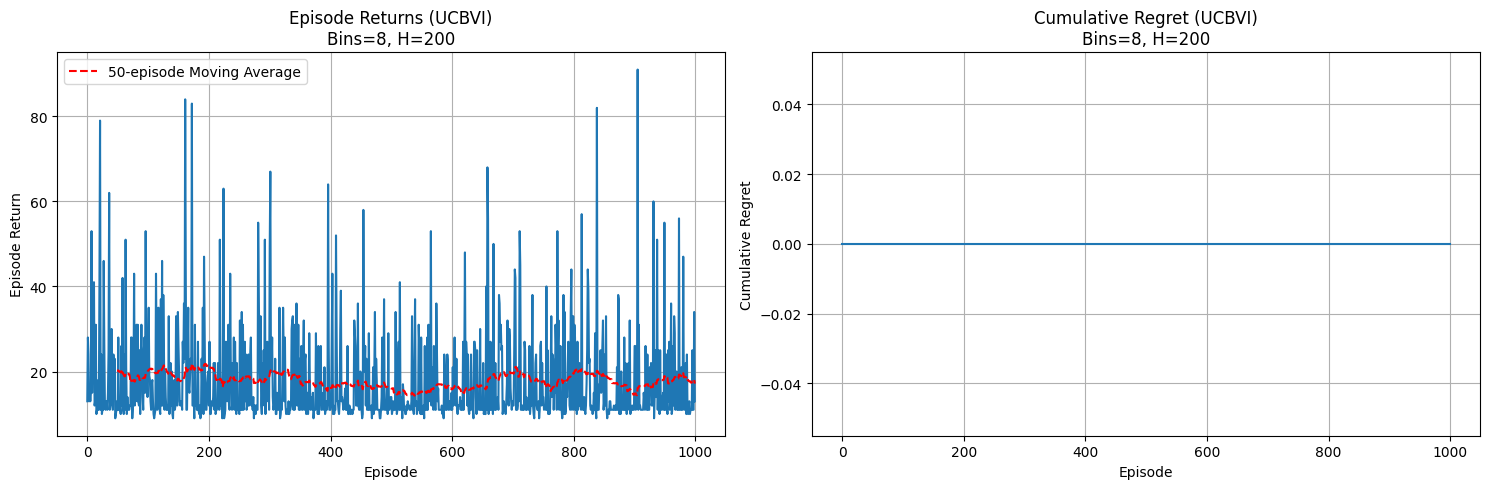

GIF episode return: 10.00


In [8]:
# Train the agent
history = train_agent(CONFIG)

# Plot the results
plot_training_results(history, CONFIG)

# Generate and display GIF
display(generate_gif(history['agent'], history['discretiser'], CONFIG))

## Comparing Different Configurations

Let's try different configurations and compare their performance:


Running experiment with UCBVI...
Discretised states: 4096 (bins per dim: 8)
Starting training with UCBVI for 500 episodes...
  UCBVI.update: s=2276, x_int=0, a_exec=0, r=1.00, s'=2276
    N[2276,0,0]=1.0->2.0, R[2276,0,0]=0.00->0.50
  UCBVI.update: s=2276, x_int=0, a_exec=1, r=1.00, s'=2340
    N[2276,0,1]=1.0->2.0, R[2276,0,1]=0.00->0.50
  UCBVI.update: s=2340, x_int=0, a_exec=0, r=1.00, s'=2276
    N[2340,0,0]=1.0->2.0, R[2340,0,0]=0.00->0.50
  UCBVI.update: s=2276, x_int=0, a_exec=0, r=1.00, s'=2276
    N[2276,0,0]=2.0->3.0, R[2276,0,0]=0.50->0.67
  UCBVI.update: s=2276, x_int=0, a_exec=0, r=1.00, s'=2277
    N[2276,0,0]=3.0->4.0, R[2276,0,0]=0.67->0.75
  UCBVI.update: s=2277, x_int=0, a_exec=1, r=1.00, s'=1764
    N[2277,0,1]=1.0->2.0, R[2277,0,1]=0.00->0.50
  UCBVI.update: s=1764, x_int=0, a_exec=1, r=1.00, s'=1772
    N[1764,0,1]=1.0->2.0, R[1764,0,1]=0.00->0.50
  UCBVI.update: s=1772, x_int=0, a_exec=0, r=1.00, s'=1772
    N[1772,0,0]=1.0->2.0, R[1772,0,0]=0.00->0.50
  UCBVI.up

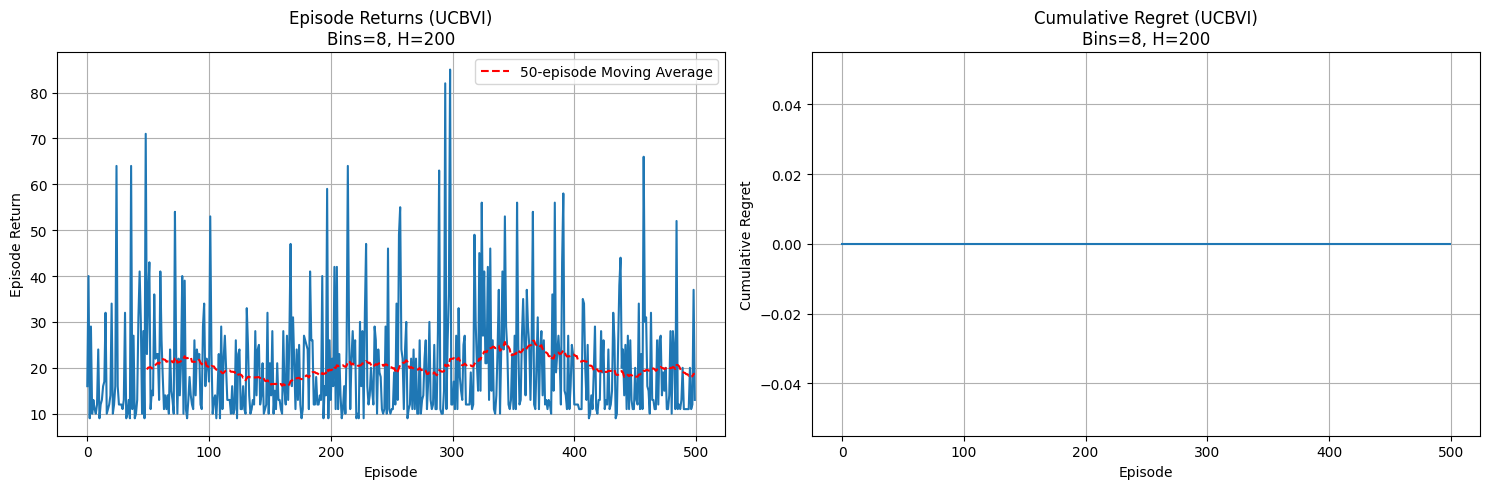

GIF episode return: 11.00



Running experiment with UCBQ...
Discretised states: 4096 (bins per dim: 8)
Starting training with UCBQ for 500 episodes...
Ep   50/500 | Return:    9.00 | Steps: 9 | Regret this ep: 0.00
Ep  100/500 | Return:   10.00 | Steps: 10 | Regret this ep: 0.00
Ep  150/500 | Return:    9.00 | Steps: 9 | Regret this ep: 0.00
Ep  200/500 | Return:    9.00 | Steps: 9 | Regret this ep: 0.00
Ep  250/500 | Return:   10.00 | Steps: 10 | Regret this ep: 0.00
Ep  300/500 | Return:    9.00 | Steps: 9 | Regret this ep: 0.00
Ep  350/500 | Return:    9.00 | Steps: 9 | Regret this ep: 0.00
Ep  400/500 | Return:    9.00 | Steps: 9 | Regret this ep: 0.00
Ep  450/500 | Return:   10.00 | Steps: 10 | Regret this ep: 0.00
Ep  500/500 | Return:    9.00 | Steps: 9 | Regret this ep: 0.00
Training finished in 0.17 seconds.


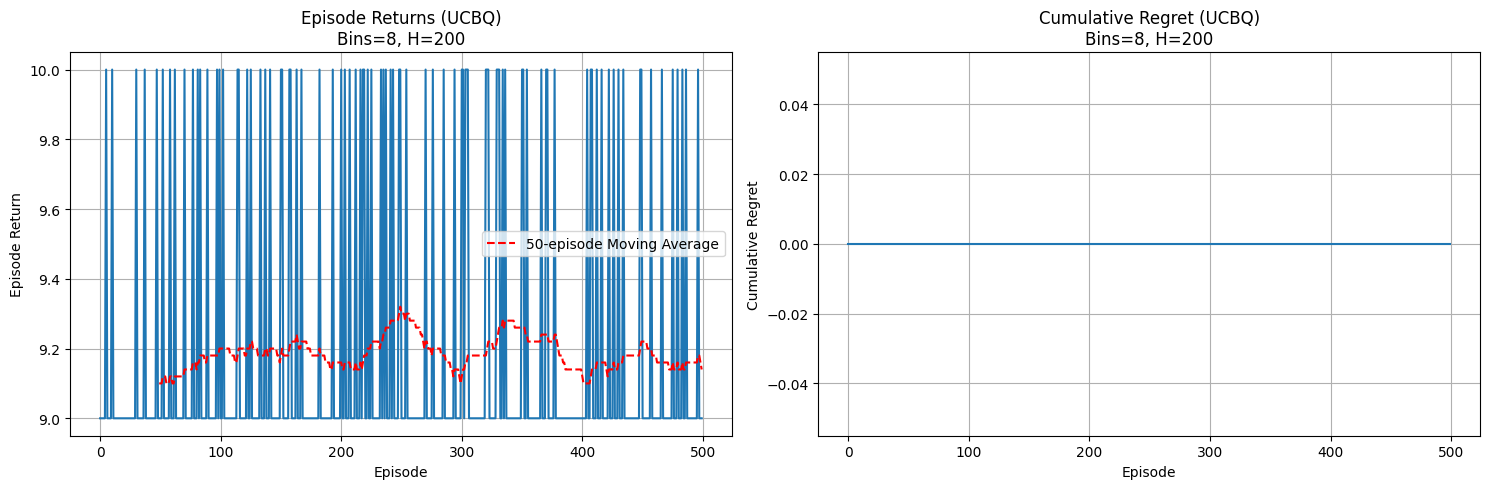

GIF episode return: 9.00



UCBVI Results:
Average return (last 50 episodes): 18.70
Final cumulative regret: 0.00
Training time: 21.99 seconds

UCBQ Results:
Average return (last 50 episodes): 9.14
Final cumulative regret: 0.00
Training time: 0.17 seconds


In [9]:
# Try different configurations
configs_to_try = [
    {'algo': 'ucbvi', 'bins': 8, 'episodes': 500, 'horizon': 200, 'delta': 0.1, 'epsilon': 0.1, 'seed': 42},
    {'algo': 'ucbq', 'bins': 8, 'episodes': 500, 'horizon': 200, 'delta': 0.1, 'epsilon': 0.1, 'seed': 42}
]

results = {}
for cfg in configs_to_try:
    print(f"\nRunning experiment with {cfg['algo'].upper()}...")
    results[cfg['algo']] = train_agent(cfg)
    plot_training_results(results[cfg['algo']], cfg)
    display(generate_gif(results[cfg['algo']]['agent'], results[cfg['algo']]['discretiser'], cfg))

# Compare final performance
for algo, res in results.items():
    print(f"\n{algo.upper()} Results:")
    print(f"Average return (last 50 episodes): {np.mean(res['returns'][-50:]):.2f}")
    print(f"Final cumulative regret: {np.sum(res['regrets']):.2f}")
    print(f"Training time: {res['training_time']:.2f} seconds")